## Data Cleaning



Features
- Language name
- Endangerment Level
- Number of speakers
- Countries in which the language is spoken - to be excluded from final model due to lack of distinct categories
- Counts of countries in which a language is recognized as an official, national, regional, minority, and widely spoken language (5 separate columns)
- Maximum urbanization rate across associated countries
- Maximum internet use across associated countries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import warnings
from rapidfuzz import process, fuzz

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
df1 = pd.read_csv('../Data/endangered_languages.csv')

### Endangered Languages Dataset
- Filter dataset to features of interest
- Address missing values while accounting for data distribution and scarcity
    - Dropped missing rows for level and missing country info
    - Imputed speaker count for Dormant (0) to 0 since Dormant means that a language is no longer actively spoken
    - Dropped remaining missing rows
- Remove certainty descriptions in output labels and empty parentheses

In [3]:
'''Drop missing rows for the output variable (endangerment level)'''

# filter to get features of interest
df1_cleaned = df1[['official_name', 'level', 'speakers', 'country']]
print(f"Number of rows before dropping null endangerment level rows: {len(df1_cleaned)}")

df1_cleaned = df1_cleaned[~df1_cleaned['level'].isna()]
print(f"Number of rows after dropping null endangerment level rows: {len(df1_cleaned)}")

Number of rows before dropping null endangerment level rows: 3466
Number of rows after dropping null endangerment level rows: 3346


In [4]:
'''Evaluate Low Certainty rows to explore potential dropping'''

# see low certainty rows
low_certainty = df1_cleaned['level'].str.contains("20 percent certain", na=False)
print("Number of rows with 20% certainty:", low_certainty.sum())
low_certainty = df1_cleaned['level'].str.contains("20 percent certain|40 percent certain", na=False)
print("Number of rows with low certainty (40% or lower):", low_certainty.sum())

# remove certainty descriptor from endangerment labels
df1_cleaned['level'] = df1_cleaned['level'].str.split('(').str[0].str.strip()

Number of rows with 20% certainty: 1939
Number of rows with low certainty (40% or lower): 2136


In [5]:
def clean_language_text(text):
    '''Cleans language names'''
    if pd.isna(text):
        return text
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[[^\]]*\]', '', text)
    text = re.sub(r'\bNone\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def clean_number_text(text):
    '''Cleans numeric text'''

    if pd.isna(text):
        return np.nan

    text = str(text).lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'\[[^\]]*\]', '', text)
    text = text.strip()

    # Handle "no" → 0 immediately
    if re.search(r'\bno\b', text):
        return 0

    # Handle completely unknown
    if 'unknown' in text:
        return np.nan

    # Handle fuzzy phrases
    fuzzy_mapping = {
        'a few': 3,
        'few': 3,
        'very few': 3,
        'small number': 3,
        'some': 3,
        'a handful': 5,
        'several hundred': 500,
        'only in the hundreds': 200,
        'several thousand': 5000,
        'hundreds': 200,
        'thousands': 3000,
        'perhaps only a few thousand': 3000,
        'one or two thousand': 2000
    }

    for phrase, value in fuzzy_mapping.items():
        if phrase in text:
            return value

    # Handle "up to" upper bound
    match = re.search(r'up to (\d+(?:,\d+)*)', text)
    if match:
        upper = match.group(1).replace(',', '')
        return int(upper)

    # Handle "over" lower bound (keep as-is)
    match = re.search(r'over (\d+(?:,\d+)*)', text)
    if match:
        lower = match.group(1).replace(',', '')
        return int(lower)

    # Handle ranges: take upper bound
    match = re.search(r'(\d+(?:,\d+)*)\s*[-–]\s*(\d+(?:,\d+)*)', text)
    if match:
        upper = match.group(2).replace(',', '')
        return int(upper)

    # Handle "estimate of X-Y"
    match = re.search(r'estimate of (\d+(?:,\d+)*)\s*[-–]\s*(\d+(?:,\d+)*)', text)
    if match:
        upper = match.group(2).replace(',', '')
        return int(upper)

    # Extract any remaining number
    match = re.search(r'\d+(?:,\d+)*', text)
    if match:
        num = match.group(0).replace(',', '')
        return int(num)

    return np.nan

def is_language(lang_series, official_names):
    '''Checks overlap between endangered languages dataset and another language column'''
    # make single string from series of language entries
    all_langs = ' '.join(lang_series.dropna().astype(str))

    # split into list, remove duplicates, and lowercase for comparison
    lang_list = all_langs.lower().split()
    unique_langs = list(dict.fromkeys(lang_list))

    # return boolean series (case-insensitive match)
    return official_names.str.lower().isin(unique_langs)

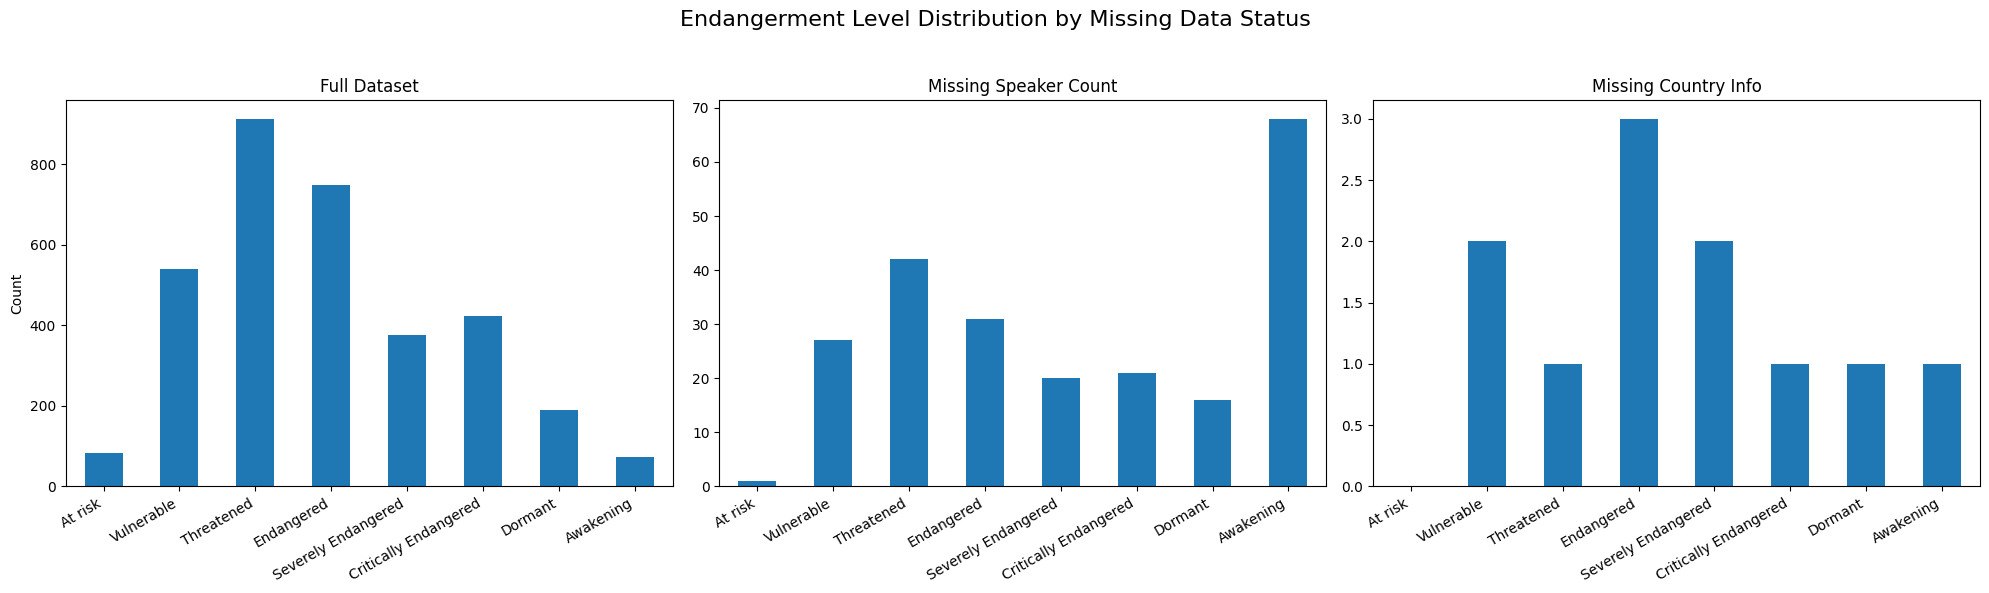

In [6]:
'''Check missing speaker count and country by language endangerment level'''

# define masks
missing_speakers = df1_cleaned['speakers'].isnull() | (df1_cleaned['speakers'].astype(str).str.lower().str.strip() == 'unknown')
missing_country = df1_cleaned['country'].isnull()

# logical order of endangerment levels
ordered_levels = [
    'At risk',
    'Vulnerable',
    'Threatened',
    'Endangered',
    'Severely Endangered',
    'Critically Endangered',
    'Dormant',
    'Awakening'
]

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# full dataset
df1_cleaned['level'].value_counts().reindex(ordered_levels).plot(kind='bar', ax=axes[0])
axes[0].set_title('Full Dataset')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

# missing speakers
df1_cleaned[missing_speakers]['level'].value_counts().reindex(ordered_levels).plot(kind='bar', ax=axes[1])
axes[1].set_title('Missing Speaker Count')
axes[1].set_xlabel('')

# missing country
df1_cleaned[missing_country]['level'].value_counts().reindex(ordered_levels).plot(kind='bar', ax=axes[2])
axes[2].set_title('Missing Country Info')
axes[2].set_xlabel('')

# format x-axis labels
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

# additional formatting
plt.suptitle('Endangerment Level Distribution by Missing Data Status', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# impute speaker count for dormant level with 0
df1_cleaned.loc[
    (df1_cleaned['level'] == 'Dormant') & (df1_cleaned['speakers'].isna()), 
    'speakers'
] = 0

# replace Awakening and Dormant with "Extinct"
df1_cleaned['level'] = df1_cleaned['level'].replace({'Awakening': 'Extinct', 'Dormant': 'Extinct'})
df1_cleaned

# drop missing speaker and country info
df1_cleaned = df1_cleaned.dropna()

# clean numbers
df1_cleaned['speakers'] = df1_cleaned['speakers'].apply(clean_number_text)

### Wikipedia - List of Official Names by Country and Territory
- Apply regex formatting to country and language columns in preparation for joining the data
- Retain missing values since some columns are not applicable and joins will remain unaffected

In [7]:
df2 = pd.read_csv("../Data/official_languages.csv")
df2_cleaned = df2.copy()
for col in df2.columns:
    if not pd.api.types.is_numeric_dtype(df2[col]):
        df2_cleaned[col] = df2[col].apply(clean_language_text)
df2_cleaned.head()

,Unnamed: 0,Country/Region,Number of official (including de facto),Official language(s),Regional language(s),Minority language(s),National language(s),Widely spoken
0,0,Abkhazia,2,Abkhaz Russian,NaN,Georgian,Abkhaz,NaN
1,1,Afghanistan,2,Persian Pashto,Uzbek Turkmen Pashayi Nuristani Balochi Pamiri,NaN,Persian Pashto,Persian
2,2,Albania,1,Albanian,NaN,Greek Macedonian Aromanian,NaN,Italian
3,3,Algeria,2,Arabic Berber,NaN,NaN,Arabic Berber,French
4,4,Andorra,1,Catalan,NaN,Spanish French Portuguese,NaN,NaN


### Wikipedia - List of Languages by Total Number of Speakers
- Apply regex formatting to language (Language) and speaker (First Language Speakers, Second Language Speakers, Total Speakers) columns
- Rename default headers to improve interpretability
- Remove first row containing headers

In [8]:
df3 = pd.read_csv("../Data/top_200_langs.csv")

# clean df3
df3.replace('—', pd.NA, inplace=True)
df3_cleaned = df3.copy()
for col in df3.columns:
    if col == 'English Language Name':
        df3_cleaned[col] = df3[col].apply(clean_language_text)
    if col == 'Number of Speakers':
        df3_cleaned[col] = df3[col].apply(clean_number_text)

df3_cleaned.rename(columns = {'English Language Name': 'Language', 'Number of Speakers': 'Total Speakers'}, inplace=True)
df3_cleaned.head()

,Position,Language,Total Speakers
0,1,English,1500000000
1,2,Mandarin Chinese,1200000000
2,3,Hindi,609100000
3,4,Spanish,558500000
4,5,Standard Arabic,334800000


### World Bank Indicators - Rate of Urbanization
- Filter to 2023
- Drop missing values

In [9]:
# load and filter df4
df4 = pd.read_csv("../Data/wb_urban.csv")
df4_cleaned = df4[['Country Name', '2023']]
del(df4)
df4_cleaned = df4_cleaned[~df4_cleaned.isna().any(axis=1)].reset_index()

### World Bank Indicators - Internet Use
- Filter to 2023
- Drop missing values


In [10]:
# load and filter df4
df5 = pd.read_csv("../Data/wb_internet.csv")
df5_cleaned = df5[['Country Name', '2023']]

# drop nan
del df5
df5_cleaned = df5_cleaned[~df5_cleaned.isna().any(axis=1)].reset_index()

### Stacking / Joining the Data
- Vertically concatenate most spoken languages dataset and label as "Not Endangered"
- Fill stacked df with count of countries in which language is official, regional, minority, national, or widely spoken
- List countries that it's spoken in
- Fill stacked df with urbanization and internet use using a combination of fuzzy matching and manual mapping for cross-dataset country matches

In [11]:
'''Concat endangered and popular language datasets'''

# copy and rename language name column
endangered_lang = df3_cleaned[['Language']].rename(columns={"Language": "official_name"})

# add missing columns
for col in df1_cleaned.columns.difference(endangered_lang.columns):
    endangered_lang[col] = np.NaN

# concat dfs and replace NaN level labels
stacked_df = pd.concat([df1_cleaned, endangered_lang], ignore_index=True)
stacked_df['level'] = stacked_df['level'].fillna('Not Endangered')

# create speaker map using cleaned language names
speaker_map = df3_cleaned.set_index('Language')['Total Speakers']

# don't cast speakers column yet - leave as float while assigning
stacked_df['speakers'] = pd.to_numeric(stacked_df['speakers'], errors='coerce')

# assign mapped values where missing
missing_speakers = stacked_df['speakers'].isna()
mapped_values = stacked_df.loc[missing_speakers, 'official_name'].map(speaker_map)

# assign float values first, safely coercing missing values to np.nan
stacked_df.loc[missing_speakers, 'speakers'] = pd.to_numeric(mapped_values, errors='coerce')

# after all assignments are done, convert entire column safely
stacked_df['speakers'] = pd.to_numeric(stacked_df['speakers'], errors='coerce').round().astype(float)

In [12]:
def count_language_tokens(lang_series, official_names):
    '''Counts how many times each full official name appears in lang_series'''
    
    lang_list = lang_series.fillna('').str.lower().tolist()
    
    # full-string match counter
    all_text = ' '.join(lang_list)
    
    return official_names.str.lower().map(lambda x: all_text.count(x))

# apply to stacked_df
stacked_df['official'] = count_language_tokens(df2_cleaned['Official language(s)'], stacked_df['official_name'])
stacked_df['regional'] = count_language_tokens(df2_cleaned['Regional language(s)'], stacked_df['official_name'])
stacked_df['minority'] = count_language_tokens(df2_cleaned['Minority language(s)'], stacked_df['official_name'])
stacked_df['national'] = count_language_tokens(df2_cleaned['National language(s)'], stacked_df['official_name'])
stacked_df['widely_spoken'] = count_language_tokens(df2_cleaned['Widely spoken'], stacked_df['official_name'])

In [13]:
'''Finds countries associated with non-endangered languages'''

# define aliases for common edge cases
semantic_aliases = {
    "Modern Standard Arabic": "Arabic",
    "Standard Arabic": "Arabic",
    "Standard German": "German",
    "Western Punjabi": "Punjabi",
    "Eastern Punjabi": "Punjabi",
    "Iranian Persian": "Persian",
    "Dari": "Persian",
    "Central Kurdish": "Kurdish",
    "Yue Chinese": "Cantonese",
    "Wu Chinese": "Wu"
}

def find_countries_for_language(language, df):
    # replace with canonical form if available
    canonical = semantic_aliases.get(language, language)

    language_columns = [
        'Official language(s)',
        'National language(s)',
        'Regional language(s)',
        'Minority language(s)',
        'Widely spoken'
    ]
    
    match_condition = False
    for col in language_columns:
        if col in df.columns:
            match_condition |= df[col].str.contains(canonical, na=False, case=False)
    
    matches = df[match_condition]
    return ";".join(matches['Country/Region'].dropna().unique())

def update_country(row):
    if pd.isna(row['country']):
        countries = find_countries_for_language(row['official_name'], df2_cleaned)
        return countries if countries else np.nan
    return row['country']

# apply the update
stacked_df['country'] = stacked_df.apply(update_country, axis=1)
stacked_df = stacked_df[~stacked_df['country'].isna()]

In [14]:
'''Fill in speaker counts for non-endangered languages'''

# language-speaker map
total_speakers_map = df3_cleaned.set_index('Language')['Total Speakers'].to_dict()

# apply map where speakers is NaN in stacked df
updated_speakers = stacked_df.apply(
    lambda row: total_speakers_map.get(row['official_name'], row['speakers']) 
                if pd.isna(row['speakers']) else row['speakers'],
    axis=1
)

# Assign safely using .loc
stacked_df.loc[:, 'speakers'] = updated_speakers
stacked_df[stacked_df['speakers'].isna()]

# drop languages that don't have speaker counts
stacked_df = stacked_df[~stacked_df['speakers'].isna()]

# change doubles to int
stacked_df['speakers'] = stacked_df['speakers'].astype(np.int64)


In [15]:
'''Concatenate World Bank dat with stacked_df'''

def count_country(country_string):
    return len([x for x in country_string.strip().split(';') if x != ""])

stacked_df['country_count'] = stacked_df['country'].apply(count_country)
stacked_df.reset_index(drop=True,inplace=True)

# apply manual mapping
manual_country_mapping = {
    'USA': 'United States',
    'Russia': 'Russian Federation',
    'Iran': 'Iran, Islamic Rep.',
    'Vietnam': 'Viet Nam',
    'Democratic Republic of the Congo': 'Congo, Dem. Rep.',
    'Laos': 'Lao PDR',
    'Micronesia': 'Micronesia, Fed. Sts.',
    'Taiwan': 'Not classified',
    'East Timor': 'Timor-Leste',
    'Venezuela': 'Venezuela, RB',
    'Egyptian Arabic': 'Egypt, Arab Rep.',
    'Wu Chinese': 'China',
}

def apply_manual_mapping(country_str):
    if pd.isna(country_str):
        return country_str
    parts = [manual_country_mapping.get(part.strip(), part.strip()) 
             for part in country_str.split(';') if part.strip()]
    return ';'.join(parts)

stacked_df['country'] = stacked_df['country'].apply(apply_manual_mapping)

# use fuzzy matching to match urbanization rates
country_list = df4_cleaned['Country Name'].tolist()

def get_max_urbanization(row, country_list, threshold=85):
    country_candidates = [c.strip() for c in str(row['country']).split(';') if c != ""]
    urbanization_rates = []

    for candidate in country_candidates:
        match, score, _ = process.extractOne(candidate, country_list, scorer=fuzz.token_sort_ratio)
        if score >= threshold:
            result = df4_cleaned.loc[df4_cleaned['Country Name'] == match, '2023']
            if not result.empty:
                urban_rate = result.values[0]
                urbanization_rates.append(urban_rate)

    if urbanization_rates:
        return max(urbanization_rates)
    else:
        return None

# use fuzzy matching to match internet use
country_list2 = df5_cleaned['Country Name'].tolist()

def get_max_internet(row, country_list, threshold=85):
    country_candidates = [c.strip() for c in str(row['country']).split(';') if c.strip() != ""]
    internet_rates = []

    for candidate in country_candidates:
        match, score, _ = process.extractOne(candidate, country_list, scorer=fuzz.token_sort_ratio)
        if score >= threshold:
            result = df5_cleaned.loc[df5_cleaned['Country Name'] == match, '2023']
            if not result.empty:
                internet_use = result.values[0]
                internet_rates.append(internet_use)

    if internet_rates:
        return max(internet_rates)
    else:
        return None

# add urbanization rate, internet use, and years since last internet use observation columns to stacked_df 
stacked_df['max_urbanization'] = stacked_df.apply(
    get_max_urbanization, axis=1, country_list=country_list
)

stacked_df['max_internet_use'] = stacked_df.apply(
    get_max_internet, axis=1, country_list=country_list2
)

stacked_df = stacked_df.dropna()

In [ ]:
# write to file
stacked_df.to_parquet("final_dataset2.parquet", index=False)
stacked_df

,official_name,level,speakers,country,official,regional,minority,national,widely_spoken,country_count,max_urbanization,max_internet_use
0,!Xun,Vulnerable,18000,South Africa;Namibia;Angola,0,0,0,0,0,3,68.819,75.7
2,(Lower) Tanana,Critically Endangered,25,United States,0,0,0,0,0,1,83.298,93.1
3,A'ingae,Vulnerable,1500,Colombia;Ecuador,0,0,0,0,0,2,82.354,77.3
4,Aasáx,Extinct,0,Tanzania,0,0,0,0,0,1,37.409,29.1
5,Abaga,Critically Endangered,5,Papua New Guinea,0,0,0,0,0,1,13.723,24.1
...,...,...,...,...,...,...,...,...,...,...,...,...
3211,Tiv,Not Endangered,5000000,"Peru;Venezuela, RB",0,1,1,0,0,2,88.438,79.5
3212,Tatar,Not Endangered,4800000,Poland;Romania;Ukraine,0,1,2,0,0,3,70.095,89.2
3213,Shan,Not Endangered,4700000,Ethiopia;Myanmar;Zimbabwe,1,1,0,1,0,3,32.517,58.5
3214,Lao,Not Endangered,4700000,Lao PDR;Viet Nam,1,0,1,0,0,2,39.480,78.1
